# importing matplotlib for plotting at the bottom of this notebook

In [2]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import time
import sys
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from datetime import datetime #added for Windows users
current_time = datetime.now() #added for Windows users
#!date #did not work on Windows
print(current_time.strftime('%m/%d/%Y %H:%M'))
!whoami

01/18/2020 21:21
benjaminmalnor


# load the transformed file

In [3]:
sys.path.insert(0, '/Users/benjaminmalnor/Library/Mobile Documents/com~apple~CloudDocs/sandbox/bus350/gtfs-realtime/')

In [4]:
import route_shape_process_scripts as f1

In [24]:
#from 03_transform_locations
route_of_interest = '7'
position_date = "201905"
shape_of_interest_id = 10007006
gtfs_merge_file_path = "../data/gtfs_merge/"
shapes_filename = [f for f in listdir(gtfs_merge_file_path) if isfile(join(gtfs_merge_file_path, f)) 
                and 'shapes' in f][0]
full_shapes_gtfs = pd.read_csv(f"{gtfs_merge_file_path}{shapes_filename}", low_memory=False)

route_vertex_geo = f1.make_geopandas_shape_df(full_shapes_gtfs, shape_of_interest_id)

In [7]:
#input_folder
input_folder = "../data/transformed/"
transformed_positions = pd.read_csv(f"{input_folder}route_{route_of_interest}_{position_date}.csv")

# below is an interactive graph if you installed `ipywidgets`

# importing interactive libraries for interactive plots at the bottom of this notebook, you can comment these out if you just want to do transformations

In [8]:
#comment out these libraries if you don't want/have interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# look at one unique trip

# compare `shape_dist_traveled_to_closest_pt` vs. `shape_dist_traveled`

In [9]:
@interact
def show_one_unique_trip(x=list(transformed_positions['month_day_trip_veh'].unique())):
    onetrip_df = transformed_positions[
    transformed_positions['month_day_trip_veh']==x][
                                                                    ['month_day_trip_veh',
                                                                     'trip_id',
                                                                     'route_id',
                                                                     'stop_name',
                                                                     'shape_pt_sequence',
                                                                     'shape_dist_traveled',
                                                                     'shape_dist_traveled_to_closest_pt',
                                                                     'time_pct',
                                                                    'trip_start_time',
                                                                    'arrival_time',
                                                                     'actual_time_from_scheduled_start',
                                                                     'scheduled_time_from_scheduled_start'
                                                                    ]]

    x = onetrip_df['shape_dist_traveled_to_closest_pt'].values
    x2 = onetrip_df['shape_dist_traveled'].values
    y1 = onetrip_df['actual_time_from_scheduled_start'].values
#     y2 = onetrip_df['scheduled_time_from_scheduled_start'].values

    x_labels = onetrip_df['stop_name'].values
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(x, y1, label='closest_projected_pt', color='red')
    ax.scatter(x2, y1, label='closest_route_vertex', color='blue')
#     ax.scatter(x, y2, label='sched_time', color='blue')
    ax.set_xlabel("distance traveled (m)")
    ax.set_ylabel("time from start (min)")
    _ = ax.legend()

interactive(children=(Dropdown(description='x', options=('2019_4_30_43272733_4558', '2019_4_30_43272943_4503',…

In [10]:
@interact
def show_one_unique_trip(x=list(transformed_positions['trip_id'].unique())):
    onetrip_df = transformed_positions[
    transformed_positions['trip_id']==x][
                                                                    ['month_day_trip_veh',
                                                                     'trip_id',
                                                                     'route_id',
                                                                     'stop_name',
                                                                     'shape_pt_sequence',
                                                                     'shape_dist_traveled',
                                                                     'shape_dist_traveled_to_closest_pt',
                                                                     'time_pct',
                                                                    'trip_start_time',
                                                                    'arrival_time',
                                                                     'actual_time_from_scheduled_start',
                                                                     'scheduled_time_from_scheduled_start'
                                                                    ]]

    x = onetrip_df['shape_dist_traveled_to_closest_pt'].values
    x2 = onetrip_df['shape_dist_traveled'].values
    y1 = onetrip_df['actual_time_from_scheduled_start'].values
#     y2 = onetrip_df['scheduled_time_from_scheduled_start'].values

    x_labels = onetrip_df['stop_name'].values
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(x, y1, label='closest_projected_pt', color='red', alpha=0.4)
    ax.scatter(x2, y1, label='closest_route_vertex', color='blue', alpha=0.4)
#     ax.scatter(x, y2, label='sched_time', color='blue')
    ax.set_xlabel("distance traveled (m)")
    ax.set_ylabel("time from start (min)")
    _ = ax.legend()

interactive(children=(Dropdown(description='x', options=(43272733, 43272943, 43272711, 43272719, 43272886, 432…

## It's good to check if our distances are significantly different using the closest distance on the route vs. the nearest route vertex's shape_dist_traveled

### First create a field of the difference between the two measurements

In [11]:
transformed_positions.loc[:,'diff_shape_distance_traveled'] = (transformed_positions
                                                               .loc[:,['shape_dist_traveled',
                                                                       'shape_dist_traveled_to_closest_pt']]
                                                                    .apply(lambda x:
                                                                     (x.shape_dist_traveled-
                                                                     x.shape_dist_traveled_to_closest_pt),
                                                                     axis=1)
                                                              )

### Second make a histogram of `diff_shape_distance_traveled` and see what it looks like

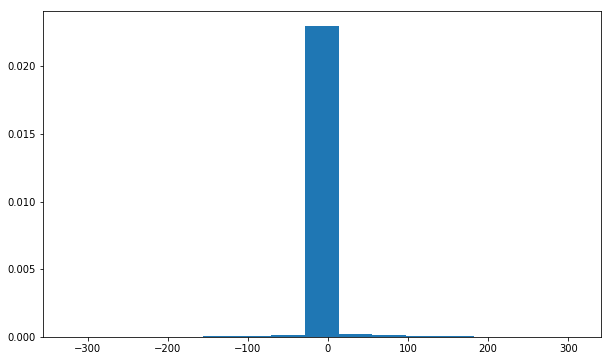

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(transformed_positions['diff_shape_distance_traveled'].values, bins=15, density=True)

# looks like there are a lot of small outliers

In [13]:
transformed_positions['diff_shape_distance_traveled'].describe()

count    65655.000000
mean        -3.048663
std         18.738809
min       -324.329431
25%         -6.445236
50%         -1.880997
75%         -0.001460
max        308.854176
Name: diff_shape_distance_traveled, dtype: float64

### from the histogram and summary statistics we can see the standard deviation

### My first guess was that some of this variance could be coming from bad vehicle location points. To investigate that option, we can look at distance from vehicle to shape distribution

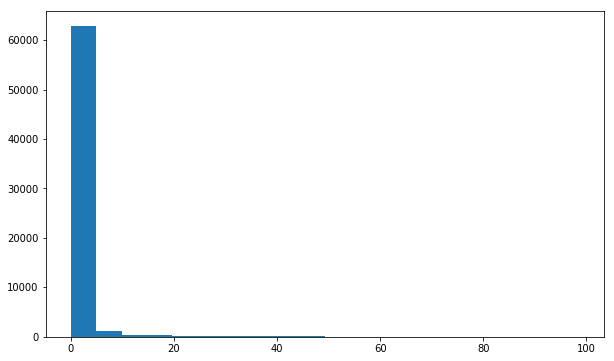

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(transformed_positions['distance_btw_veh_and_shape'].values, bins=20)

In [15]:
transformed_positions['distance_btw_veh_and_shape'].describe()

count    65655.000000
mean         2.090968
std          5.453702
min          0.001661
25%          0.542422
50%          0.846226
75%          2.120860
max         98.401656
Name: distance_btw_veh_and_shape, dtype: float64

### look at the standard deviation for the distance between vehicle and shape and use that to filter below

In [16]:
veh_dist_to_shape_std_dev = transformed_positions['distance_btw_veh_and_shape'].describe()['std']
len(transformed_positions[transformed_positions['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev])

2690

In [17]:
transformed_positions[transformed_positions['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev][
                                                                    ['month_day_trip_veh',
                                                                     'trip_id',
                                                                     'hour',
                                                                     'dow',
                                                                     'route_id',
                                                                     'stop_name',
                                                                     'shape_pt_sequence',
                                                                     'distance_btw_veh_and_shape',
                                                                     'shape_dist_traveled',
                                                                     'shape_dist_traveled_to_closest_pt',
                                                                     'actual_time_from_scheduled_start'
                                                                    ]].head(3)

,month_day_trip_veh,trip_id,hour,dow,route_id,stop_name,shape_pt_sequence,distance_btw_veh_and_shape,shape_dist_traveled,shape_dist_traveled_to_closest_pt,actual_time_from_scheduled_start
45,2019_4_30_43272719_4559,43272719,17,1,100263,NaN,185,22.829119,31869.3,31945.116138,38.433333
46,2019_4_30_43272711_4540,43272711,17,1,100263,NaN,106,18.718767,17019.3,16957.535217,20.500000
47,2019_4_30_43272886_4557,43272886,17,1,100263,NaN,251,15.392008,44321.1,44371.281583,60.516667


## Let's inspect the vehicle points far from the route shape vertex in a map below. I like using Carto's basemaps (they're free! and I think less glitchy than Leaflet plugin). In order to run the cells below you'll need to install the following:
- `pip install carto`
- `pip install cartoframes==1.0b7`

In [18]:
from cartoframes.viz import Map, Layer, basemaps, Popup
from cartoframes.viz.helpers import color_continuous_layer, color_bins_layer, utils
from matplotlib import cm
from cartoframes.data import dataset

## plot far vehicles

In [25]:
far_vehicles = transformed_positions[transformed_positions['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev]

###############################################
## vehicle points ############################
###############################################

vehicle_pt_df = far_vehicles[['shape_pt_sequence','vehicle_lat','vehicle_long']].copy()
geometry = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry=geometry.tolist())

###############################################
## route vertex points ####### route_vertex_geo
###############################################

display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         )
    ]
))

# From the map above, it looks like the vehicle location is far from a route_vertex when 
- there are significant gaps in the route vertices (long straight roads in the route)
- and the vehicle is off the route

## let's try plotting the vehicle point projected on the route vs. the nearest route vertex for these cases. This is when Nathaniel's method shines :)

In [41]:
transformed_positions.loc[:,'fixed_closest_coords'] = transformed_positions.loc[:,'closest_pt_coords'].apply(lambda x: list(map(float,x.replace("[","").replace("]","").split())))

In [45]:
far_vehicles = transformed_positions[transformed_positions['distance_btw_veh_and_shape']>veh_dist_to_shape_std_dev]

###############################################
## closest points ############################
###############################################

closest_pt_df = far_vehicles[['time_pct','fixed_closest_coords',
                                  'shape_dist_traveled_to_closest_pt',
                                  'actual_time_from_scheduled_start']].copy()
closest_pt_df['geometry'] = closest_pt_df['fixed_closest_coords'].apply(lambda x: Point(x))
closest_pt_df.drop(['fixed_closest_coords'], axis=1, inplace=True)
closest_pt_geo = gpd.GeoDataFrame(closest_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## vehicle points ############################
###############################################

vehicle_pt_df = far_vehicles[['time_pct','vehicle_lat','vehicle_long','shape_dist_traveled',
                                      'shape_pt_sequence','distance_btw_veh_and_shape',
                                      'actual_time_from_scheduled_start']].copy()
vehicle_pt_df['geometry'] = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## route vertex points ####### route_vertex_geo
###############################################

display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'click': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(closest_pt_geo,
           'color: red',
           popup=Popup({
        'hover': {
            'title': 'shape_dist_traveled_to_closest_pt',
            'value': '$shape_dist_traveled_to_closest_pt'
        }
    })
         )

    ]
))

# in the map above, you can see the red points hugging the route shape. 
- this works when there are gaps in the route 
- this _does not work_ when the bus goes off the route

In [46]:
far_vehicles.loc[:,"vehicle_shape_pt_hour"] = (far_vehicles.loc[:,['vehicle_id','shape_pt_sequence','hour']]
                                               .apply(lambda x: str(x['vehicle_id'])
                                                                +"_"+
                                                                 str(x['shape_pt_sequence'])
                                                                +"_"+
                                                                str(x['hour']),
                                                     axis=1).copy())

/Users/benjaminmalnor/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/benjaminmalnor/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [48]:
@interact
def show_one_unique_trip(x=list(far_vehicles['vehicle_shape_pt_hour'].unique())):
    ###############################################
    ## closest points ############################
    ###############################################
    
    specific_far_vehicle = far_vehicles[far_vehicles['vehicle_shape_pt_hour']==x].copy()
    
    shape_pt_sequence = specific_far_vehicle['shape_pt_sequence'].values[0]

    closest_pt_df = specific_far_vehicle[['time_pct','fixed_closest_coords',
                                      'shape_dist_traveled_to_closest_pt',
                                      'actual_time_from_scheduled_start']].copy()
    closest_pt_df['geometry'] = closest_pt_df['fixed_closest_coords'].apply(lambda x: Point(x))
    closest_pt_df.drop(['fixed_closest_coords'], axis=1, inplace=True)
    closest_pt_geo = gpd.GeoDataFrame(closest_pt_df, crs={'init':'4326'},geometry='geometry')

    ###############################################
    ## vehicle points ############################
    ###############################################

    vehicle_pt_df = specific_far_vehicle[['time_pct','vehicle_lat','vehicle_long','shape_dist_traveled',
                                          'shape_pt_sequence','distance_btw_veh_and_shape',
                                          'actual_time_from_scheduled_start']].copy()
    vehicle_pt_df['geometry'] = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
    vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry='geometry')
    
#     adjacent_pt_data = f2.get_adjacent_shape_point_data(full_shapes_gtfs, shape_pt_sequence, 
#                                                         use_index=False, use_shape_pt_sequence=True)
#     adjacent_list = adjacent_pt_data['shape_pt_sequence'].tolist()
#     adjacent_list.append(shape_pt_sequence_of_interest)
#     route_pts = route_vertex_geo[route_vertex_geo['shape_pt_sequence'].isin(adjacent_list)]

    
    display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'hover': {
            
            'title':'shape_dist_traveled',
            'value': '$shape_dist_traveled'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'hover': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(closest_pt_geo,
           'color: red',
           popup=Popup({
        'hover': {
            'title': 'shape_dist_traveled_to_closest_pt',
            'value': '$shape_dist_traveled_to_closest_pt'
        }
    })
         )

    ]
))

interactive(children=(Dropdown(description='x', options=('4559_185_17', '4540_106_17', '4557_251_17', '4503_16…

# let's remove 
- if  it is the first or last shape point, only take vehicle observations  with `distance_btw_veh_and_shape` that are < 1 std dev
- if it is not a first/last shape point, take vehicle observations, that are 2*`distance_btw_veh_and_shape` std dev

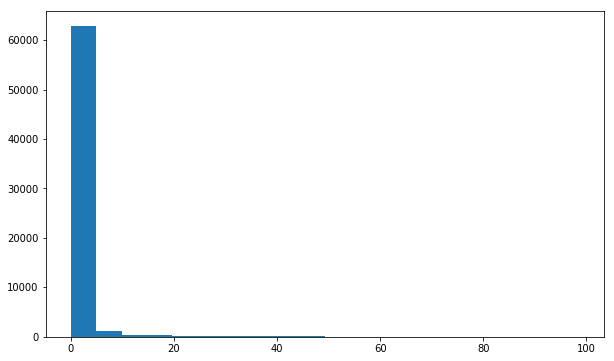

In [49]:
filtered_position_w_node_schedule = transformed_positions[transformed_positions['distance_btw_veh_and_shape']
                                                          <100].copy()

fig, ax = plt.subplots(figsize=(10,6))
_ = ax.hist(filtered_position_w_node_schedule['distance_btw_veh_and_shape'].values, bins=20)

# plot all again after filter

In [51]:
###############################################
## closest points ############################
###############################################

closest_pt_df = filtered_position_w_node_schedule[['time_pct','fixed_closest_coords','shape_pt_sequence',
                                  'shape_dist_traveled_to_closest_pt','month_day_trip_veh',
                                  'actual_time_from_scheduled_start']].copy()
closest_pt_df['geometry'] = closest_pt_df['fixed_closest_coords'].apply(lambda x: Point(x))
closest_pt_df.drop(['fixed_closest_coords'], axis=1, inplace=True)
closest_pt_geo = gpd.GeoDataFrame(closest_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## vehicle points ############################
###############################################

vehicle_pt_df = filtered_position_w_node_schedule[['time_pct','vehicle_lat','vehicle_long','shape_dist_traveled',
                                      'shape_pt_sequence','distance_btw_veh_and_shape','month_day_trip_veh',
                                      'actual_time_from_scheduled_start']].copy()
vehicle_pt_df['geometry'] = vehicle_pt_df.apply(lambda x: Point(x.vehicle_long, x.vehicle_lat), axis=1)
vehicle_pt_geo = gpd.GeoDataFrame(vehicle_pt_df, crs={'init':'4326'},geometry='geometry')

###############################################
## route vertex points ####### route_vertex_geo
###############################################

display(Map(

    [Layer(route_vertex_geo,
          'color: black',
           popup=Popup({
        'click': {
            'title': 'shape_pt_sequence',
            'value': '$shape_pt_sequence'
        }
    })
         ),
     Layer(vehicle_pt_geo,
           'color: blue',
           popup=Popup({
        'click': {
            'title': 'month_day_trip_veh',
            'value': '$month_day_trip_veh'
        }
    })
         ),
     Layer(closest_pt_geo,
           'color: red',
           popup=Popup({
        'click': {
            'title': 'month_day_trip_veh',
            'value': '$month_day_trip_veh'
        }
    })
         )

    ]
))